# Ref: Kernels


https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields

https://www.kaggle.com/artgor/nn-baseline

https://www.kaggle.com/ogrellier/user-level-lightgbm-lb-1-4480

https://www.kaggle.com/dimitreoliveira/deep-learning-keras-ga-revenue-prediction


# setup and import

In [2]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from sklearn.preprocessing import LabelEncoder

path = '../data/'
print(os.listdir(path))

['test_adj.csv', 'test_dropped.csv', 'sample_submission.csv', 'train_dropped.csv', 'user_test.csv', 'train_orig.csv', 'test_parsed.csv', 'user_test_n.csv', 'train_parsed.csv', 'train_adj.csv', 'test_orig.csv', 'user_train.csv', 'user_train_n.csv']


# Parse data

In [2]:
def load_df(csv_path, nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, 
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df

In [5]:
%%time
df_train = load_df(path + 'train_orig.csv')

CPU times: user 1min 47s, sys: 3.06 s, total: 1min 50s
Wall time: 1min 50s


In [6]:
%%time
df_train.to_csv(path + 'train_parsed.csv')

CPU times: user 21 s, sys: 516 ms, total: 21.6 s
Wall time: 22.7 s


In [3]:
%%time
df_test = load_df(path + 'test_orig.csv')

CPU times: user 1min 35s, sys: 2.75 s, total: 1min 38s
Wall time: 1min 37s


In [4]:
%%time
df_test.to_csv(path + 'test_parsed.csv')

CPU times: user 18.9 s, sys: 492 ms, total: 19.4 s
Wall time: 19.7 s


# delete columns with no valid info

In [6]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from sklearn.preprocessing import LabelEncoder

path = '../data/'
print(os.listdir(path))

['sample_submission.csv', 'train_orig.csv', 'test_parsed.csv', 'train_parsed.csv', 'test_orig.csv']


In [7]:
%%time
df_train = pd.read_csv(path +'train_parsed.csv', index_col = 0, dtype={'fullVisitorId': 'str'})
df_test = pd.read_csv(path +'test_parsed.csv', index_col = 0, dtype={'fullVisitorId': 'str'})

/home/kyokicchi/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (50) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
cols_to_drop = [col for col in df_train.columns if df_train[col].nunique() < 2]
cols_to_drop = [col for col in cols_to_drop if col in df_test.columns]
cols_to_drop

In [11]:
df_train.drop(cols_to_drop, axis=1, inplace=True)
df_test.drop(cols_to_drop, axis=1, inplace=True)

In [12]:
%%time
df_train.to_csv(path + 'train_dropped.csv')
df_test.to_csv(path + 'test_dropped.csv')

CPU times: user 21.9 s, sys: 376 ms, total: 22.2 s
Wall time: 22.6 s


# apply adjustments

In [29]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from sklearn.preprocessing import LabelEncoder

path = '../data/ggl/'
print(os.listdir(path))

['test_dropped.csv', 'sample_submission.csv', 'train_dropped.csv', 'train_orig.csv', 'test_parsed.csv', 'train_parsed.csv', 'test_orig.csv']


In [30]:
%%time
df_train = pd.read_csv(path +'train_dropped.csv', index_col = 0, dtype={'fullVisitorId': 'str'})
df_test = pd.read_csv(path +'test_dropped.csv', index_col = 0, dtype={'fullVisitorId': 'str'})

<string>:2: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 9.01 s, sys: 680 ms, total: 9.69 s
Wall time: 9.28 s


## only for train dataset

In [31]:
# to float and log
df_train['transactionRevenue'] = df_train['transactionRevenue'].astype(float)
df_train['transactionRevenue'] = np.log1p(df_train['transactionRevenue'].fillna(0))

df_train.drop('campaignCode', axis=1, inplace=True)


## to both train and test datasets

In [32]:
%%time
df_train = df_train.fillna(0)
df_test = df_test.fillna(0)

CPU times: user 3.31 s, sys: 919 ms, total: 4.23 s
Wall time: 3.41 s


### group columns

In [33]:

dont_touch = ['fullVisitorId', 'transactionRevenue',]

bind_cols = ['browser', 'deviceCategory','isMobile','adContent','adwordsClickInfo.adNetworkType','adwordsClickInfo.page',
             'adwordsClickInfo.slot', 'campaign',  'medium']

del_cols = ['sessionId', 'visitId','city','networkDomain','keyword','adwordsClickInfo.gclId','date','dummy','metro','region','referralPath']

cat_cols = ['country','operatingSystem','subContinent','source']

onehot_cols = ['channelGrouping','continent']

num_cols = ['visitNumber','visitStartTime','hits','pageviews',]


### analyze date

In [34]:

def dateCol(df):
# fix and breakdown date info
    df['date'] = pd.to_datetime(df['date'].apply(lambda x: str(x)[:4] + '-' + str(x)[4:6] + '-' + str(x)[6:]))
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['weekday'] = df['date'].dt.weekday
    df['weekofyear'] = df['date'].dt.weekofyear
    df['weekend'] = df['weekday'].apply(lambda x: 1 if x>=5 else 0)
    
    return df

df_train = dateCol(df_train)
df_test = dateCol(df_test)

### bind and drop

In [35]:
%%time

#bind_cols = ['browser', 'deviceCategory','isMobile','adContent','adwordsClickInfo.adNetworkType','adwordsClickInfo.page',
#             'adwordsClickInfo.slot', 'campaign','campaignCode',  'medium']

df_train['isMobile'] = df_train['isMobile'] * 1
df_train['browser_cat'] = df_train['browser'] + '_' + df_train['deviceCategory'] + '_' + df_train['isMobile'].astype(str)

df_train['ads_1'] = df_train['adContent'].astype(str) + '_' + df_train['adwordsClickInfo.adNetworkType'].astype(str) \
+ '_' + df_train['adwordsClickInfo.page'].astype(str)
df_train['ads_2'] = df_train['adwordsClickInfo.slot'].astype(str) + '_' + df_train['campaign'].astype(str) \
+ '_' + df_train['medium'].astype(str)


df_test['isMobile'] = df_test['isMobile'] * 1
df_test['browser_cat'] = df_test['browser'] + '_' + df_test['deviceCategory'] + '_' + df_test['isMobile'].astype(str)

df_test['ads_1'] = df_test['adContent'].astype(str) + '_' + df_test['adwordsClickInfo.adNetworkType'].astype(str) \
+ '_' + df_test['adwordsClickInfo.page'].astype(str)
df_test['ads_2'] = df_test['adwordsClickInfo.slot'].astype(str) + '_' + df_test['campaign'].astype(str) \
+ '_' + df_test['medium'].astype(str)


for x in bind_cols:
    df_train.drop(x, axis=1, inplace=True)
    df_test.drop(x, axis=1, inplace=True)

CPU times: user 6.64 s, sys: 2.01 s, total: 8.65 s
Wall time: 7.79 s


### access count column

In [36]:
%%time
def userCount(df):
    df['dummy'] = 1
    df['user_cumcnt_per_day'] = (df[['fullVisitorId','date', 'dummy']].groupby(['fullVisitorId','date'])['dummy'].cumcount()+1)
    df['user_sum_per_day'] = df[['fullVisitorId','date', 'dummy']].groupby(['fullVisitorId','date'])['dummy'].transform(sum)
    df['user_cumcnt_sum_ratio_per_day'] = df['user_cumcnt_per_day'] / df['user_sum_per_day'] 

    return df

df_train = userCount(df_train)
df_test = userCount(df_test)

CPU times: user 6.62 s, sys: 837 ms, total: 7.46 s
Wall time: 6.19 s


### category string to numbers

In [37]:
%%time

#cat_cols = ['country','operatingSystem','subContinent','source']
cat_cols.extend(['browser_cat','ads_1','ads_2'])

for col in cat_cols:
    lbl = LabelEncoder()
    lbl.fit(list(df_train[col].values.astype('str')) + list(df_test[col].values.astype('str')))
    df_train[col] = lbl.transform(list(df_train[col].values.astype('str')))
    df_test[col] = lbl.transform(list(df_test[col].values.astype('str')))


CPU times: user 37.6 s, sys: 9.86 s, total: 47.5 s
Wall time: 39.6 s


### One-Hot columns

In [38]:
%%time
#onehot_cols = ['channelGrouping','continent']

def oneHot(df,col):
    dum = pd.get_dummies(df[col], drop_first = True)
    df = pd.concat((df, dum),axis = 1)
    df = df.drop(col,axis = 1)
    return df

for x in onehot_cols:
    df_train = oneHot(df_train,x)
    df_test = oneHot(df_test,x)


CPU times: user 3.2 s, sys: 2.16 s, total: 5.36 s
Wall time: 3.16 s


### delete columns

In [39]:
%%time

#del_cols = ['sessionId', 'visitId','city','networkDomain','keyword','adwordsClickInfo.gclId','date','dummy','metro','region','referralPath']


for x in del_cols:
    df_train.drop(x, axis=1, inplace=True)
    df_test.drop(x, axis=1, inplace=True)



CPU times: user 1.98 s, sys: 1.73 s, total: 3.72 s
Wall time: 1.91 s


In [44]:
%%time

#dont_touch = ['fullVisitorId', 'transactionRevenue',]
l_float = [x for x in df_train.columns if x not in dont_touch]

df_train[l_float] = df_train[l_float].values.astype('float')
df_test[l_float] = df_test[l_float].values.astype('float')


CPU times: user 6.99 s, sys: 3.34 s, total: 10.3 s
Wall time: 5.6 s


### save adjusted DFs

In [46]:
%%time
df_train.to_csv(path + 'train_adj.csv')
df_test.to_csv(path + 'test_adj.csv')

CPU times: user 30.4 s, sys: 235 ms, total: 30.7 s
Wall time: 30.7 s


# create new dataset: aggregated by users

In [47]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from sklearn.preprocessing import LabelEncoder

path = '../data/ggl/'
print(os.listdir(path))

['test_adj.csv', 'test_dropped.csv', 'sample_submission.csv', 'train_dropped.csv', 'train_orig.csv', 'test_parsed.csv', 'train_parsed.csv', 'train_adj.csv', 'test_orig.csv']


In [48]:
%%time
df_train = pd.read_csv(path +'train_adj.csv', index_col = 0, dtype={'fullVisitorId': 'str'})
df_test = pd.read_csv(path +'test_adj.csv', index_col = 0, dtype={'fullVisitorId': 'str'})

CPU times: user 5.49 s, sys: 354 ms, total: 5.85 s
Wall time: 5.53 s


In [61]:
    aggs = {
        'visitNumber' : ['sum', 'min', 'max', 'mean'],
        'visitStartTime' : ['min', 'max', 'mean'],
        'operatingSystem' : ['min', 'max', 'mean'],
        'country' : ['mean'],
        'subContinent' : ['mean'],
        'hits' : ['sum', 'min', 'max', 'mean'],
        'pageviews' : ['sum', 'min', 'max', 'mean'],
        'transactionRevenue' : ['sum', 'size'],
        'source' : ['mean'],
        'month' : ['min', 'max', 'mean'],
        'day' : ['min', 'max', 'mean'],
        'weekday' : ['mean'],
        'weekofyear' : ['min', 'max', 'mean'],
        'weekend' : ['mean'],
        'browser_cat' : ['mean'],
        'ads_1' : ['mean'],
        'ads_2' : ['mean'],
        'user_cumcnt_per_day' : ['sum', 'min', 'max', 'mean'],
        'user_sum_per_day' : ['sum', 'min', 'max', 'mean'],
        'user_cumcnt_sum_ratio_per_day' : ['mean'],
        'Affiliates' : ['mean'],
        'Direct' : ['mean'],
        'Display' : ['mean'],
        'Organic Search' : ['mean'],
        'Paid Search' : ['mean'],
        'Referral' : ['mean'],
        'Social' : ['mean'],
        'Africa' : ['mean'],
        'Americas' : ['mean'],
        'Asia' : ['mean'],
        'Europe' : ['mean'],
        'Oceania' : ['mean']
    }

In [62]:

def aggregate_by_users(df, aggs):

    users = df.groupby('fullVisitorId').agg(aggs)

    new_columns = [ k + '_' + agg for k in aggs.keys() for agg in aggs[k] ]
    users.columns = new_columns

    return users

In [63]:
%%time

df_test['transactionRevenue'] = 0

df_user_train = aggregate_by_users(df_train, aggs)
df_user_test = aggregate_by_users(df_test, aggs)


CPU times: user 11.2 s, sys: 4.71 s, total: 15.9 s
Wall time: 9.39 s


In [70]:
print(df_train.shape)
print(df_train.fullVisitorId.nunique())
print(df_user_train.shape)


(903653, 33)
714167
(714167, 58)


In [73]:
%%time
df_user_train = df_user_train.fillna(0)
df_user_test = df_user_test.fillna(0)

df_user_train.to_csv(path + 'user_train.csv')
df_user_test.to_csv(path + 'user_test.csv')

CPU times: user 44.5 s, sys: 616 ms, total: 45.1 s
Wall time: 44.8 s


# Normalize

In [1]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

path = '../data/'
print(os.listdir(path))

['test_adj.csv', 'test_dropped.csv', 'sample_submission.csv', 'train_dropped.csv', 'user_test.csv', 'train_orig.csv', 'test_parsed.csv', 'user_test_n.csv', 'train_parsed.csv', 'train_adj.csv', 'test_orig.csv', 'user_train.csv', 'user_train_n.csv']


In [5]:
%%time
df_user_train = pd.read_csv(path +'user_train.csv', index_col = 0, dtype={'fullVisitorId': 'str'})
df_user_test = pd.read_csv(path +'user_test.csv', index_col = 0, dtype={'fullVisitorId': 'str'})


CPU times: user 10.1 s, sys: 514 ms, total: 10.6 s
Wall time: 10.3 s


In [8]:
%%time

tgt = [x for x in df_user_train.columns if x not in ['fullVisitorId','transactionRevenue_sum'] ]

sc = MinMaxScaler()
df_user_train[tgt] = sc.fit_transform(df_user_train[tgt])
df_user_test[tgt] = sc.transform(df_user_test[tgt])

CPU times: user 13.4 s, sys: 2.22 s, total: 15.6 s
Wall time: 8.62 s


In [12]:
%%time
df_user_train.to_csv(path + 'user_train_n.csv')
df_user_test.to_csv(path + 'user_test_n.csv')

CPU times: user 1min 5s, sys: 888 ms, total: 1min 6s
Wall time: 1min 7s


# visualize correlations

In [15]:
%%time
df_user_train = pd.read_csv(path +'user_train_n.csv', index_col = 0, dtype={'fullVisitorId': 'str'})
df_user_train.drop('transactionRevenue_sum', axis = 1, inplace=True)


CPU times: user 8.43 s, sys: 352 ms, total: 8.78 s
Wall time: 8.57 s


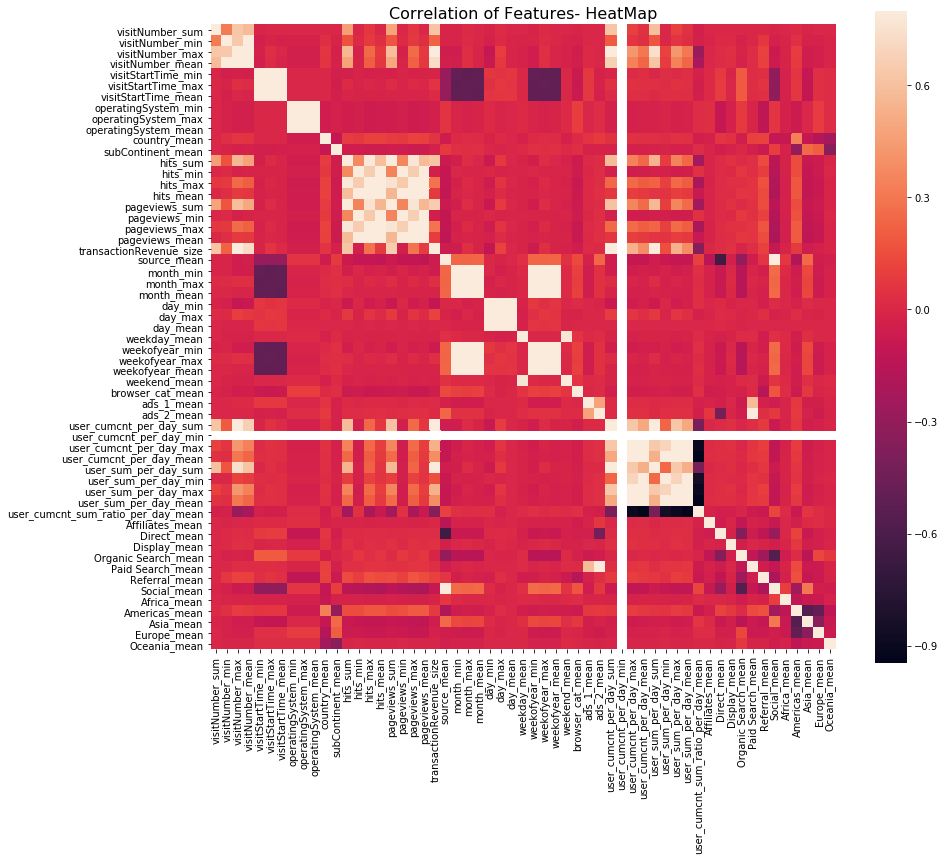

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

f , ax = plt.subplots(figsize = (14,12))
plt.title('Correlation of Features- HeatMap',y=1,size=16)
sns.heatmap(df_user_train.corr(),square = True,  vmax=0.8)
